**Late submission**

Since I have not used any honey pots during our semester, I am using them for this late submission🍯🦔

**Data**

I've decided to use Henry Hub Natural Gas Spot Price monthly data as my dataset for the task. I have extracted the data from the [U.S. Energy Information Administration website](https://www.eia.gov/dnav/ng/hist/rngwhhdM.htm) . I've picked the larged time span I could to capture the context of the world largest crises such as 2008 housing crisis and 2000 dot-com crash. Otherwise, the recent crisis of 2022 would be significant outlier.

In [1]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
!pip install pmdarima statsmodels

# Loading the dataset
file_path = 'HHNG.csv'
data = pd.read_csv(file_path, sep=';')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.index = data.index.to_period('M')
data.index = data.index.to_timestamp(how='start') # first day of the month
data.index.freq = 'MS'
print(data)


            Price
Date             
1997-01-01   3.45
1997-02-01   2.15
1997-03-01   1.89
1997-04-01   2.03
1997-05-01   2.25
...           ...
2024-08-01   1.99
2024-09-01   2.28
2024-10-01   2.20
2024-11-01   2.12
2024-12-01   3.01

[336 rows x 1 columns]


<ipython-input-1-d558a1fde510>:20: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'])


**Visualization**


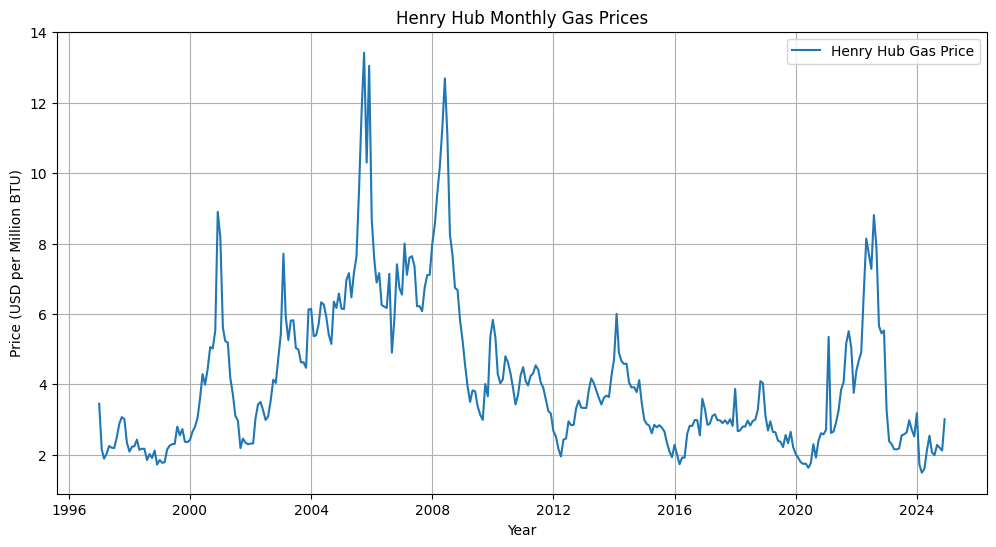

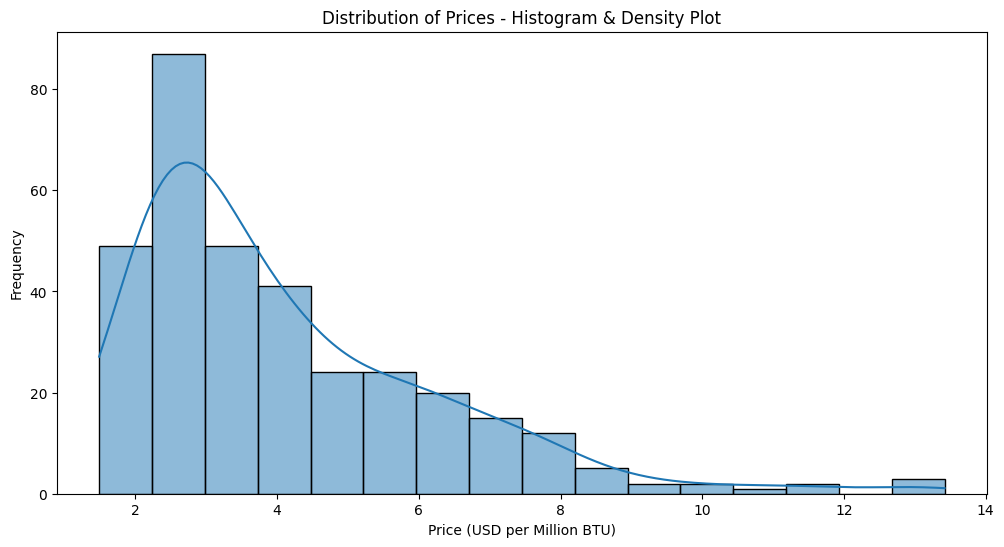

<Figure size 1200x600 with 0 Axes>

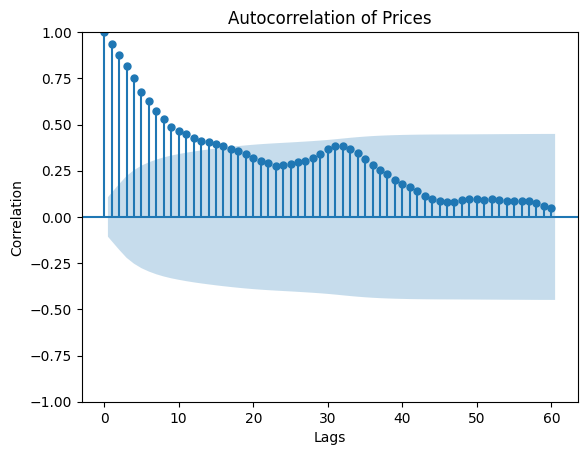

In [2]:
# Line
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Price'], label='Henry Hub Gas Price')
plt.title('Henry Hub Monthly Gas Prices')
plt.xlabel('Year')
plt.ylabel('Price (USD per Million BTU)')
plt.legend()
plt.grid(True)
plt.show()

# Histogram
plt.figure(figsize=(12, 6))
sns.histplot(data['Price'], kde=True)
plt.title('Distribution of Prices - Histogram & Density Plot')
plt.xlabel('Price (USD per Million BTU)')
plt.ylabel('Frequency')
plt.show()

# Autocorrelation
plt.figure(figsize=(12, 6))
plot_acf(data['Price'], lags=60)  # I chose 60, since it stands for exaclty 5 years
plt.title('Autocorrelation of Prices')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

The line chart provides us with the fundamental price dynamics over the whole time series. If we look closely we can already see that it has seasonallity as in one way or another the chart seem to mimic itself. From the histogram we can observe that the price typically obtains values from 2 to 4, its skew represents short term hikes up to 13-14, which are likely to be due to issues in the world economical and political landscape, since they are clearly short term and the "fair" value is close to 2$. I found the autocorrelation chart interesting, as it shows that the most recent prices have the strongest impact on the next price, with effect fading away rapidly, however around lags=30 and lags 50~60, which is roughly 2.5 years and 4-5 years respectively, we can see a significant spike, which could represent the seasonal effect and suggests a cycle of 2.5 years or similar.

I have decided to do a roughly 80/20 split for testing (82/18 to be fair), because 2020 seemed to be the begining of a new cycle for the world economy, which is typically set by the crises, such as 1990s oil shock, 2000 dot-com crash and 2008 housing crises, which is proven by the dynamics on the graph.

**Splitting the sample**

Training set covers from 1997-01-01 00:00:00 to 2019-12-01 00:00:00
Testing set covers from 2020-01-01 00:00:00 to 2024-12-01 00:00:00


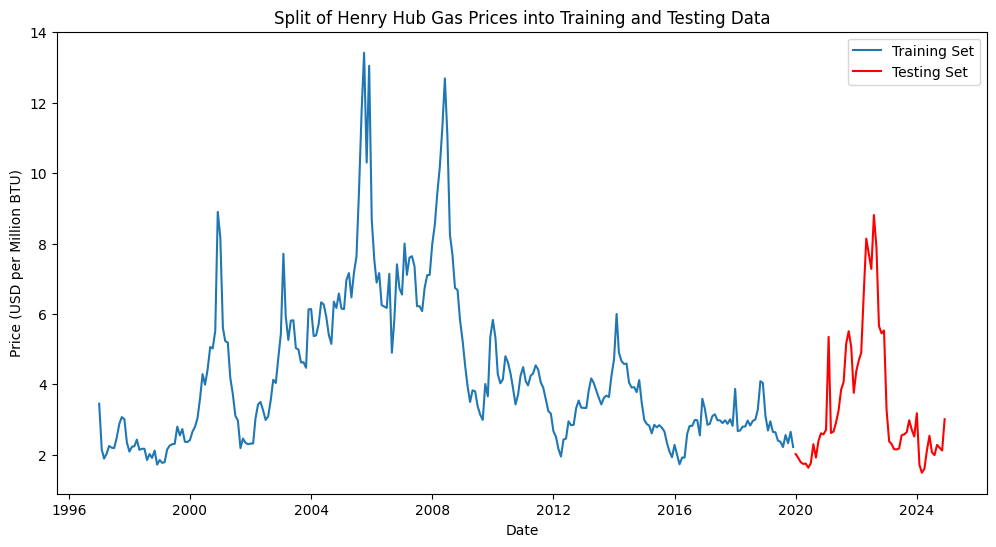

In [3]:
training_size = 276  # Number of months for training
testing_size = 60    # Number of months for testing

# Split
train = data.iloc[:training_size]
test = data.iloc[training_size:training_size + testing_size]

# Verify the split
print("Training set covers from", train.index.min(), "to", train.index.max())
print("Testing set covers from", test.index.min(), "to", test.index.max())

# Plot the new sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Price'], label='Training Set')
plt.plot(test.index, test['Price'], label='Testing Set', color='red')
plt.title('Split of Henry Hub Gas Prices into Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Price (USD per Million BTU)')
plt.legend()
plt.show()

**Decomposition**

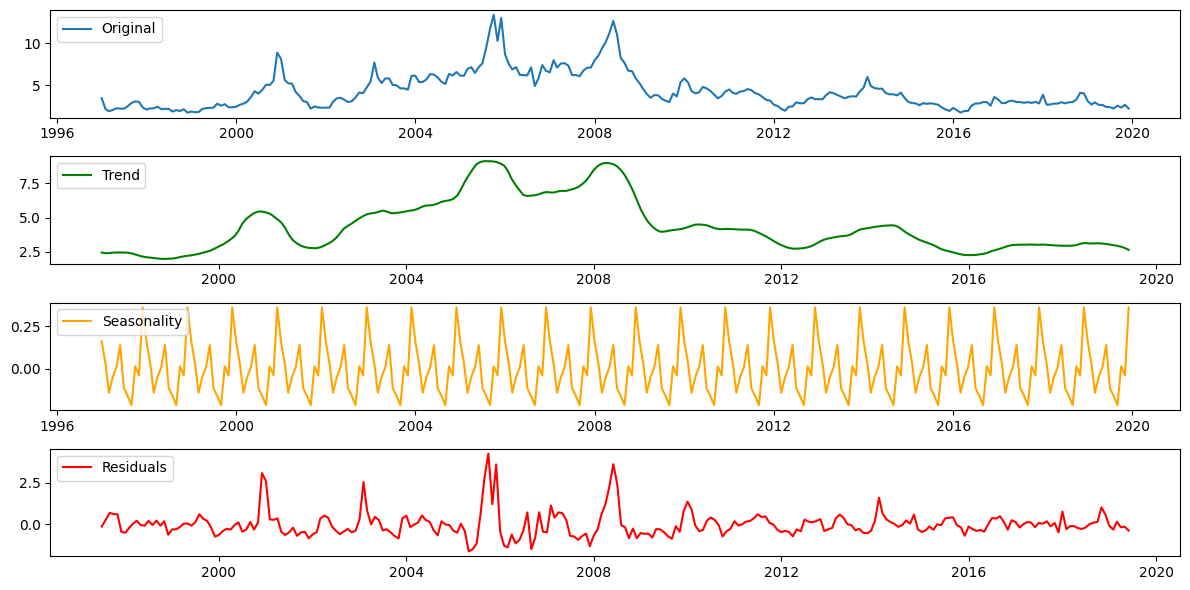

In [4]:
# Seasonal decomposition of the training data
decomposition = seasonal_decompose(train['Price'], model='additive', period=12)

# Plotting the decomposed components
plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(train['Price'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality', color ='orange')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

**Gradient Boosting forecast**


Test Set Evaluation:

Gradient Boosting Metrics:
RMSE: 0.96
MAE: 0.66
R² Score: 0.75
MAPE: 19.11%


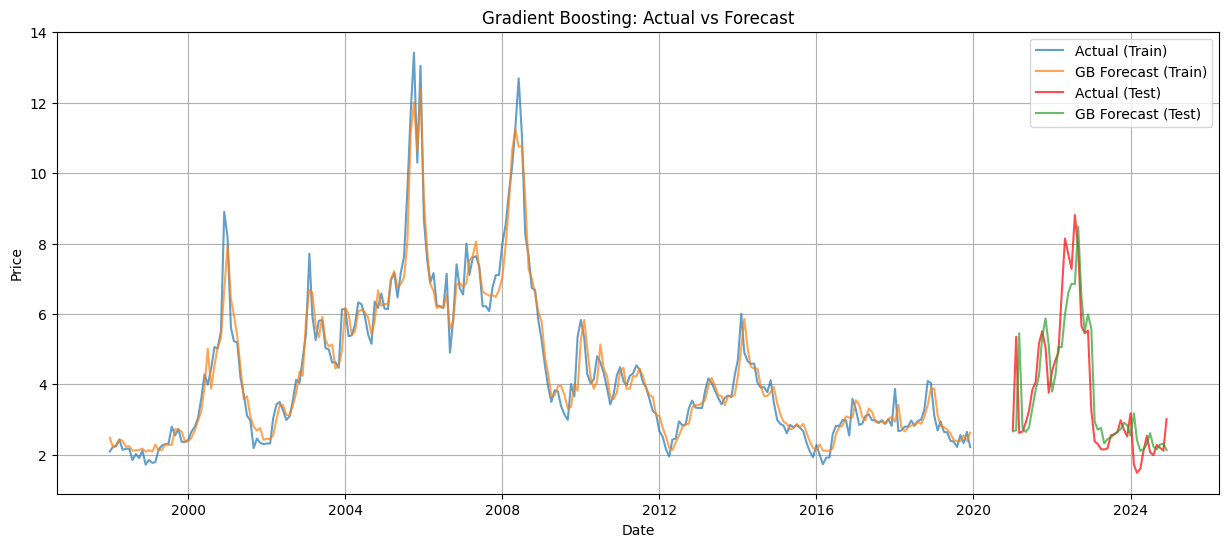

            Price
Date             
1997-01-01   3.45
1997-02-01   2.15
1997-03-01   1.89
1997-04-01   2.03
1997-05-01   2.25
...           ...
2019-08-01   2.22
2019-09-01   2.56
2019-10-01   2.33
2019-11-01   2.65
2019-12-01   2.22

[276 rows x 1 columns]


In [5]:
# Function to create features
def create_features(data, target, lookback):
    X = []  # Features (past prices)
    y = []  # Target (future price)
    values = data[target].values
    for i in range(lookback, len(values)):
        X.append(values[i-lookback:i])
        y.append(values[i])
    return np.array(X), np.array(y)

# Lookback period is 12 month, due to annual seasonality
lookback = 12

# Features for the training data
X_train, y_train = create_features(train, 'Price', lookback)

# Features for the test data
X_test, y_test = create_features(test, 'Price', lookback)

# Gradient Boosting model parameters
gb_model = GradientBoostingRegressor(
    n_estimators=1500,
    learning_rate=0.1,
    max_depth=2,
    validation_fraction=0.15,
    n_iter_no_change=30,
    tol=0.01,
    random_state=42
)

# Fit the model using only training data
gb_model.fit(X_train, y_train)

# Make forecasts
gb_train_pred = gb_model.predict(X_train)
gb_test_pred = gb_model.predict(X_test)

# Functions to evaluate models
def mean_absolute_percentage_error(y_true, y_pred):
    # Prevent division by zero (replace 0 values with a small number)
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"\n{model_name} Metrics:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.2f}")
    print(f"MAPE: {mape:.2f}%")

# Evaluate the model
print("\nTest Set Evaluation:")
evaluate_model(y_test, gb_test_pred, "Gradient Boosting")

# Plot the results
plt.figure(figsize=(15, 6))

# Plot training predictions
plt.plot(train.index[lookback:], y_train, label='Actual (Train)', alpha=0.7)
plt.plot(train.index[lookback:], gb_train_pred, label='GB Forecast (Train)', alpha=0.7)

# Plot test predictions
plt.plot(test.index[lookback:], y_test, label='Actual (Test)', alpha=0.7, color='red')
plt.plot(test.index[lookback:], gb_test_pred, label='GB Forecast (Test)', alpha=0.7)

plt.title('Gradient Boosting: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
print(train)

**ETS model**



ETS Model - Test Set Evaluation:

ETS Metrics:
RMSE: 2.76
MAE: 2.02
R² Score: -1.09
MAPE: 43.27%


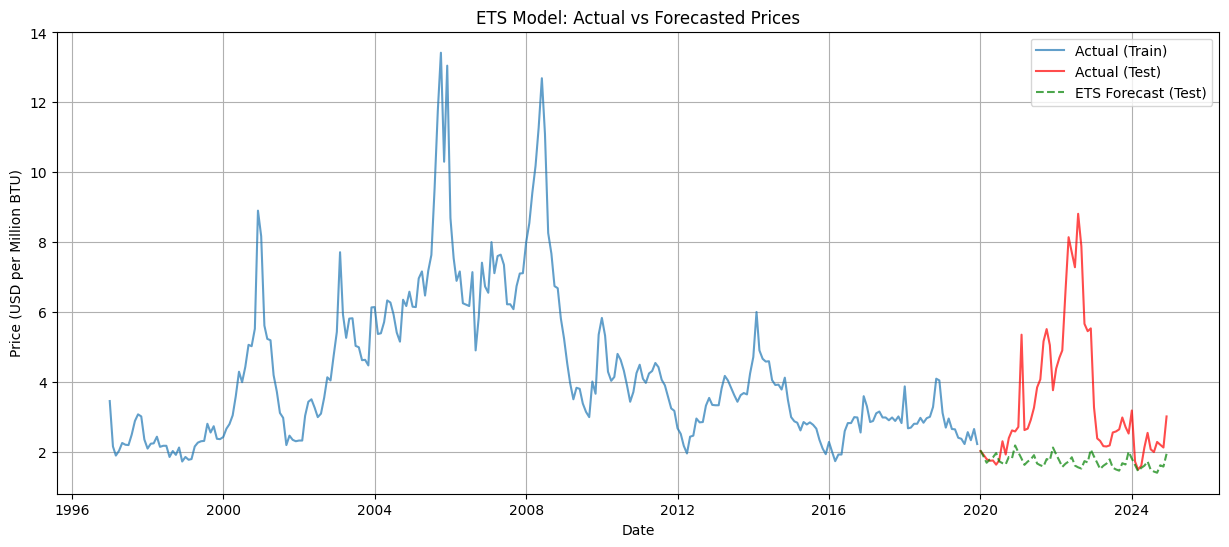

In [6]:
# Train ETS Model
ets_model = ExponentialSmoothing(
    train['Price'],
    trend='add',
    seasonal='add',
    seasonal_periods=12,
    damped_trend=False
).fit()

# Forecast the test horizon
ets_test_pred = ets_model.forecast(steps=len(test))

# Adjust test data to match the predictions length
# We need to account for the lookback period used in the previous GB model
test_values = test['Price'].values[lookback:]

print("\nETS Model - Test Set Evaluation:")
evaluate_model(test_values, ets_test_pred[:len(test_values)], "ETS")

# Plot the ETS results
plt.figure(figsize=(15, 6))

plt.plot(train.index, train['Price'], label='Actual (Train)', alpha=0.7)
plt.plot(test.index, test['Price'], label='Actual (Test)', alpha=0.7, color='red')
plt.plot(test.index, ets_test_pred, label='ETS Forecast (Test)',
         alpha=0.7, color='green', linestyle='--')

plt.title('ETS Model: Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD per Million BTU)')
plt.legend()
plt.grid(True)
plt.show()

**SARIMA model**

Starting improved SARIMA analysis...

Recommended differencing order: 1
Recommended seasonal differencing order: 0

Finding optimal SARIMA parameters...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=624.922, Time=0.13 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=625.983, Time=0.24 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=627.455, Time=1.74 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=626.076, Time=1.24 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=627.723, Time=2.37 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=629.452, Time=5.04 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=627.378, Time=1.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=629.358, Time=2.85 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=12.86 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=626.615, Time=0.23 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=627.544, Time=1.13 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=628.927, Time=2.05 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=627.658, Time=0.85 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=629.228, Time=1.42 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=630.925, Time=2.59 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=628.851, Time=0.81 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=630.820, Time=3.29 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=3.84 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=628.448, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=629.300, Time=0.23 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,2)[12] intercept   : AIC=630.651, Time=0.67 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=629.426, Time=0.19 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=630.952, Time=0.44 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,2)[12] intercept   : AIC=632.651, Time=1.18 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=630.586, Time=0.45 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(2,0,1)[12] intercept   : AIC=632.540, Time=1.37 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=630.448, Time=0.15 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,1)[12] intercept   : AIC=631.195, Time=0.32 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(0,0,2)[12] intercept   : AIC=632.414, Time=0.78 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,0)[12] intercept   : AIC=631.354, Time=0.27 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(1,0,1)[12] intercept   : AIC=632.776, Time=0.74 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,3)(2,0,0)[12] intercept   : AIC=632.333, Time=1.50 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,0)[12] intercept   : AIC=631.917, Time=0.45 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(0,0,1)[12] intercept   : AIC=632.679, Time=1.18 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,4)(1,0,0)[12] intercept   : AIC=632.830, Time=0.83 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=626.600, Time=0.08 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=627.516, Time=0.39 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=628.891, Time=1.18 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=627.633, Time=0.24 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=629.194, Time=0.33 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=630.890, Time=0.89 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=628.815, Time=0.47 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=630.783, Time=0.87 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.07 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=621.456, Time=0.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=619.117, Time=0.55 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=618.684, Time=1.41 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=620.054, Time=0.61 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=619.393, Time=0.96 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=620.669, Time=6.55 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=619.018, Time=1.93 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=620.341, Time=11.89 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=630.448, Time=1.64 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=620.640, Time=4.27 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=620.197, Time=5.44 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=621.644, Time=2.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=620.910, Time=4.20 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=620.534, Time=2.12 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,0)[12] intercept   : AIC=624.579, Time=0.39 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,0,1)[12] intercept   : AIC=621.480, Time=0.92 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(1,0,0)[12] intercept   : AIC=622.612, Time=0.76 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,0,0)[12] intercept   : AIC=625.086, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=628.430, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=629.244, Time=0.24 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,2)[12] intercept   : AIC=630.571, Time=0.62 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=629.377, Time=0.22 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=630.879, Time=0.53 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,0,2)[12] intercept   : AIC=632.571, Time=1.12 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=630.508, Time=0.58 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=632.456, Time=1.07 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=623.244, Time=0.36 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=620.700, Time=1.84 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=620.260, Time=4.65 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=621.693, Time=0.81 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=620.971, Time=1.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=620.598, Time=1.77 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=620.315, Time=0.76 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=618.871, Time=1.64 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=619.536, Time=1.51 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=620.679, Time=0.90 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=630.410, Time=0.09 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,1)[12] intercept   : AIC=630.980, Time=0.26 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,2)[12] intercept   : AIC=632.080, Time=1.05 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=631.178, Time=0.93 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(1,0,1)[12] intercept   : AIC=632.483, Time=2.53 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(2,0,0)[12] intercept   : AIC=632.003, Time=1.88 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[12] intercept   : AIC=624.765, Time=0.55 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,1)[12] intercept   : AIC=621.791, Time=1.03 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(1,0,0)[12] intercept   : AIC=622.909, Time=1.03 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=620.674, Time=0.58 sec
 ARIMA(4,1,0)(0,0,0)[12] intercept   : AIC=631.689, Time=0.18 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,1)[12] intercept   : AIC=632.155, Time=0.29 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(1,0,0)[12] intercept   : AIC=632.368, Time=0.34 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[12] intercept   : AIC=625.174, Time=0.46 sec

Best model:  ARIMA(1,1,1)(0,0,2)[12] intercept
Total fit time: 140.234 seconds


<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])


Completed 0/60 forecasts


<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as

Completed 12/60 forecasts


<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as

Completed 24/60 forecasts


<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as

Completed 36/60 forecasts


<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as

Completed 48/60 forecasts


<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rolling_predictions.append(pred[0])
<ipython-input-7-47dc21591f2a>:84: FutureWarning: Series.__getitem__ treating keys as

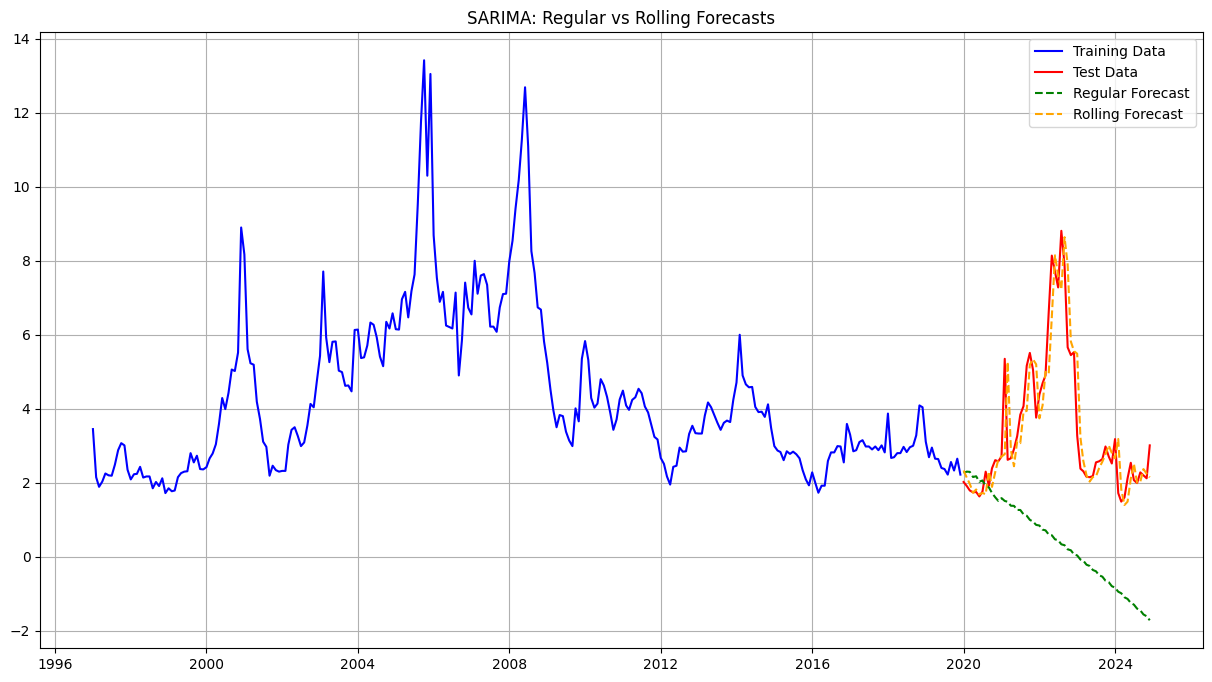

In [7]:
# Tuning SARIMA parameter search
def find_optimal_sarima_params(train_data):
    print("\nFinding optimal SARIMA parameters...")

    auto_model = pm.auto_arima(
        train_data,
        seasonal=True,
        m=12,
        start_p=0, max_p=4,
        start_q=0, max_q=4,
        start_P=0, max_P=2,
        start_Q=0, max_Q=2,
        d=None, D=None,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=False,
        random_state=42,
        n_fits=50
    )

    return auto_model.order, auto_model.seasonal_order

# Implement SARIMA with additional features
def implement_improved_sarima(train_data, test_data):
    # First, check if differencing is needed
    diff_order = pm.arima.ndiffs(train_data)
    seasonal_diff_order = pm.arima.nsdiffs(train_data, m=12)

    print(f"\nRecommended differencing order: {diff_order}")
    print(f"Recommended seasonal differencing order: {seasonal_diff_order}")

    # Find optimal parameters
    order, seasonal_order = find_optimal_sarima_params(train_data)

    # Create and fit the model
    model = SARIMAX(
        train_data,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False,
        hamilton_representation=False,
        trend='ct'
    )

    fitted_model = model.fit(
        disp=False,
        method='lbfgs',
        maxiter=500
    )

    # Generate forecast
    train_pred = fitted_model.get_prediction(start=0)
    train_predictions = train_pred.predicted_mean
    test_predictions = fitted_model.get_forecast(
        steps=len(test_data),
        dynamic=False
    ).predicted_mean

    # Calculate confidence intervals for test predictions
    forecast_conf_int = fitted_model.get_forecast(
        steps=len(test_data)
    ).conf_int(alpha=0.05)

    return train_predictions, test_predictions, forecast_conf_int, fitted_model

# Since SARIMA by itself had poor abillity to forecast our data, let's introduce rolling forecast
def generate_rolling_forecast(model, train_data, test_data, window_size=12):
    """Generate rolling forecasts for test period"""
    rolling_predictions = []
    history = train_data.copy()

    for t in range(len(test_data)):
        model_temp = SARIMAX(
            history,
            order=model.specification['order'],
            seasonal_order=model.specification['seasonal_order'],
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)

        pred = model_temp.forecast(steps=1)
        rolling_predictions.append(pred[0])

        # Update history with actual value
        history = pd.concat([history, pd.Series(test_data.iloc[t:t+1])])

        # Print progress
        if t % 12 == 0:
            print(f"Completed {t}/{len(test_data)} forecasts")

    return np.array(rolling_predictions)

# Improved plotting function with confidence intervals
def plot_improved_sarima_results(train_data, test_data, train_pred, test_pred, conf_int):
    plt.figure(figsize=(15, 8))

    # Plot training data and predictions
    plt.plot(train_data.index, train_data, label='Training Data', color='blue')
    plt.plot(train_data.index, train_pred, label='Training Predictions',
             color='green', linestyle='--', alpha=0.7)

    # Plot test data and predictions
    plt.plot(test_data.index, test_data, label='Test Data', color='red')
    plt.plot(test_data.index, test_pred, label='Test Predictions',
             color='orange', linestyle='--', alpha=0.7)

    # Plot confidence intervals
    plt.fill_between(test_data.index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1],
                    color='orange', alpha=0.2,
                    label='95% Confidence Interval')

    plt.title('SARIMA: Training and Test Predictions with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution function
def run_improved_sarima_analysis(train, test):
    print("Starting improved SARIMA analysis...")

    # Regular predictions
    train_pred, test_pred, conf_int, model = implement_improved_sarima(
        train['Price'],
        test['Price']
    )

    # Generate rolling predictions
    rolling_predictions = generate_rolling_forecast(
        model,
        train['Price'],
        test['Price']
    )

    # Plot both regular and rolling predictions
    plt.figure(figsize=(15, 8))
    plt.plot(train.index, train['Price'], label='Training Data', color='blue')
    plt.plot(test.index, test['Price'], label='Test Data', color='red')
    plt.plot(test.index, test_pred, label='Regular Forecast',
             linestyle='--', color='green')
    plt.plot(test.index, rolling_predictions, label='Rolling Forecast',
             linestyle='--', color='orange')
    plt.title('SARIMA: Regular vs Rolling Forecasts')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_pred, test_pred, rolling_predictions, model

# Execute the improved analysis
train_pred, test_pred, rolling_pred, model = run_improved_sarima_analysis(train, test)


**Comparison of all 3 models**

By comparing the 3 models we can see that Gradient Boosting and SARIMA (rolling) had the highest accuracy on the test sets, with Gradient boosting being just slightly better. ETS failed to make adequate predictions. It is possible that I messed up somewhere or used the wrong parameters, or the model was just not fit for this data, because there are clearly more factors than yearly seasonality in this data set.



Length of Actual predictions: 48
Length of Gradient Boosting predictions: 48
Length of ETS predictions: 48
Length of SARIMA predictions: 48

Comparison of All Models:
      Gradient Boosting    ETS  SARIMA
RMSE               0.96   2.81    0.95
MAE                0.66   2.08    0.65
R²                 0.75  -1.16    0.75
MAPE              19.11  45.21   18.14


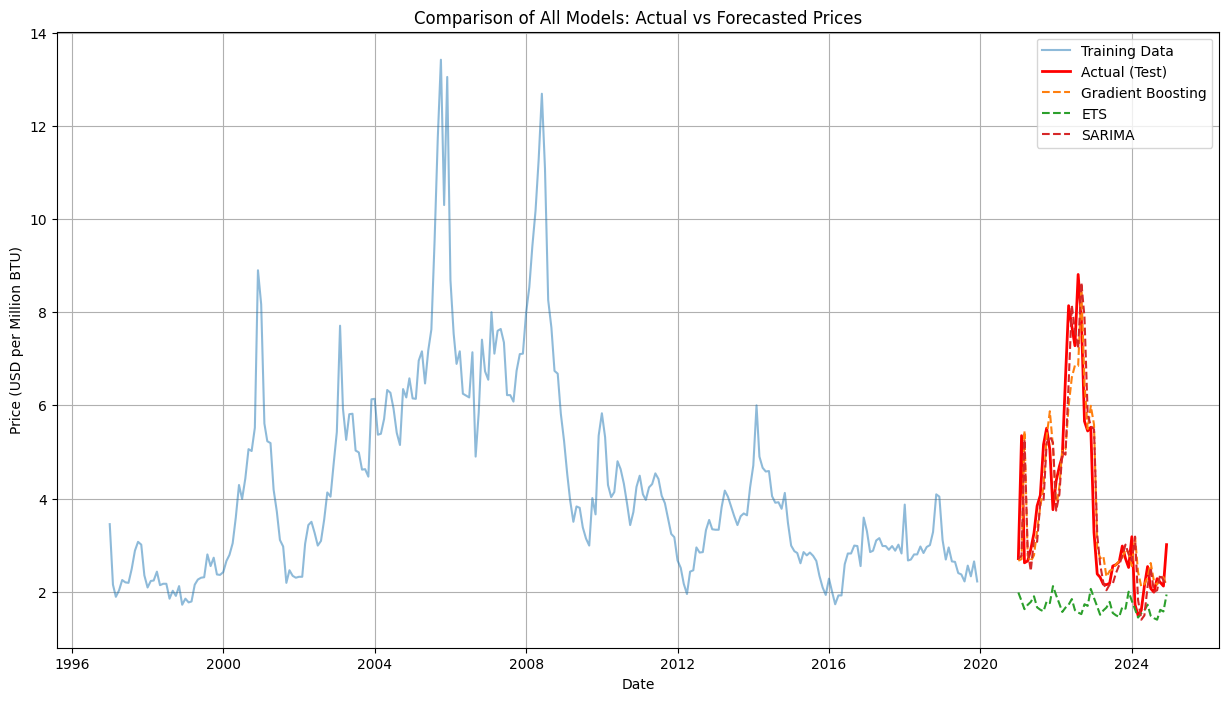

In [8]:
# Create a dictionary to store all predictions and actual values
test_data_length = len(test['Price'].values[lookback:])

predictions = {
    'Actual': test['Price'].values[lookback:],
    'Gradient Boosting': gb_test_pred[:test_data_length],
    'ETS': ets_test_pred[lookback:lookback+test_data_length],
    'SARIMA': rolling_pred[lookback:lookback+test_data_length]  # Using rolling predictions
}

# Verify lengths are equal
for key, value in predictions.items():
    print(f"Length of {key} predictions: {len(value)}")

# Calculate metrics for all models
metrics = {}
models = ['Gradient Boosting', 'ETS', 'SARIMA']

for model in models:
    try:
        metrics[model] = {
            'RMSE': np.sqrt(mean_squared_error(predictions['Actual'], predictions[model])),
            'MAE': mean_absolute_error(predictions['Actual'], predictions[model]),
            'R²': r2_score(predictions['Actual'], predictions[model]),
            'MAPE': mean_absolute_percentage_error(predictions['Actual'], predictions[model])
        }
    except Exception as e:
        print(f"Error calculating metrics for {model}: {str(e)}")

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame(metrics).round(2)
print("\nComparison of All Models:")
print(metrics_df)

# Plot all models' predictions
plt.figure(figsize=(15, 8))

try:
    # Plot training data
    plt.plot(train.index, train['Price'], label='Training Data', alpha=0.5)

    # Plot test data and predictions
    test_index = test.index[lookback:lookback+test_data_length]

    plt.plot(test_index, predictions['Actual'], label='Actual (Test)', linewidth=2, color='red')
    plt.plot(test_index, predictions['Gradient Boosting'], label='Gradient Boosting', linestyle='--')
    plt.plot(test_index, predictions['ETS'], label='ETS', linestyle='--')
    plt.plot(test_index, predictions['SARIMA'], label='SARIMA', linestyle='--')

    plt.title('Comparison of All Models: Actual vs Forecasted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price (USD per Million BTU)')
    plt.legend()
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error in plotting predictions: {str(e)}")